In [1]:
pip install tensorflow pandas


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\maryc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# ----------------------------------------------------------
# 1. Define paths and read CSV
# ----------------------------------------------------------
base_dir = r"C:/Users/maryc/Downloads/chicken/broiler-chicken-healthy-and-sick"
train_dir = os.path.join(base_dir, "train")
csv_file = os.path.join(train_dir, "_classes.csv")

# Read the CSV
data = pd.read_csv(csv_file)

# ----------------------------------------------------------
# 2. Convert (Healthy, Sick) columns into a single "label"
# ----------------------------------------------------------
# Remove rows that might be invalid, e.g., (Healthy=0,Sick=0) or (Healthy=1,Sick=1).
# If you have rows with (1,1) intentionally, remove or handle them similarly.
data = data[~((data['Healthy'] == 0) & (data['Sick'] == 0))]  # remove (0,0)
data = data[~((data['Healthy'] == 1) & (data['Sick'] == 1))]  # remove (1,1) if not valid

def row_to_label(row):
    if row["Healthy"] == 1 and row["Sick"] == 0:
        return "Healthy"
    elif row["Healthy"] == 0 and row["Sick"] == 1:
        return "Sick"
    else:
        return None  # Just in case there's an unexpected combination

data["label"] = data.apply(row_to_label, axis=1)

# Rename "filename" to "images" so it matches x_col="images"
data.rename(columns={"filename":"images"}, inplace=True)

# ----------------------------------------------------------
# 3. Set up ImageDataGenerators
# ----------------------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# ----------------------------------------------------------
# 4. Create DataFrame Generators for training and validation
# ----------------------------------------------------------
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data,
    directory=train_dir,      # folder containing the images
    x_col="images",           # filenames
    y_col="label",            # single string label: "Healthy" or "Sick"
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical", # automatically converts to one-hot for 2 classes
    subset="training",
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=data,
    directory=train_dir,
    x_col="images",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("Class Indices:", train_generator.class_indices)
# Expect something like: {'Healthy': 0, 'Sick': 1}

num_classes = len(train_generator.class_indices)  # should be 2

# ----------------------------------------------------------
# 5. Build the Pre-trained Model (VGG16) + custom layers
# ----------------------------------------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ----------------------------------------------------------
# 6. Freeze the base model layers (initial training)
# ----------------------------------------------------------
for layer in base_model.layers:
    layer.trainable = False

# ----------------------------------------------------------
# 7. Compile
# ----------------------------------------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-7,
                              verbose=1)

# ----------------------------------------------------------
# 8. Train (Initial Phase)
# ----------------------------------------------------------
epochs_initial = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs_initial,
    callbacks=[early_stop, reduce_lr]
)

# ----------------------------------------------------------
# 9. Fine-tuning (Optional)
# ----------------------------------------------------------
# Unfreeze last block of VGG16 (block5) or a portion
unfreeze_from = 15  # adjust as needed, or find layer index for block5
for layer in base_model.layers[unfreeze_from:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs_fine = 10
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs_fine,
    callbacks=[early_stop, reduce_lr]
)

# ----------------------------------------------------------
# 10. Evaluate on Validation Set + Additional Metrics
# ----------------------------------------------------------
val_loss, val_accuracy = model.evaluate(
    validation_generator,
    steps=validation_generator.samples // validation_generator.batch_size
)
print(f"Validation Accuracy (Keras .evaluate): {val_accuracy*100:.2f}%")

# For F1, Precision, Recall, we need predictions
validation_generator.reset()
y_pred_probs = model.predict(
    validation_generator,
    steps=np.ceil(validation_generator.samples / validation_generator.batch_size)
)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes  # ground-truth labels

f1 = f1_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f"Validation Accuracy:  {accuracy*100:.2f}%")
print(f"Validation F1 Score:  {f1*100:.2f}%")
print(f"Validation Recall:    {recall*100:.2f}%")
print(f"Validation Precision: {precision*100:.2f}%")

# ----------------------------------------------------------
# 11. Save the Model
# ----------------------------------------------------------
model.save('chicken_disease_model.h5')
print("Model saved as chicken_disease_model.h5")


Found 346 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.
Class Indices: {'Healthy': 0, 'Sick': 1}
Epoch 1/10
10/10 [==============================] - 84s 8s/step - loss: 0.7614 - accuracy: 0.4904 - val_loss: 0.6435 - val_accuracy: 0.6719 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 68s 7s/step - loss: 0.7083 - accuracy: 0.5669 - val_loss: 0.6668 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 72s 7s/step - loss: 0.7537 - accuracy: 0.5000 - val_loss: 0.6542 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 72s 7s/step - loss: 0.6999 - accuracy: 0.5637 - val_loss: 0.6033 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 73s 7s/step - loss: 0.6740 - accuracy: 0.5796 - val_loss: 0.6020 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - 71s

In [2]:
pip install scikit-learn



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\maryc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


PLOT METRICS

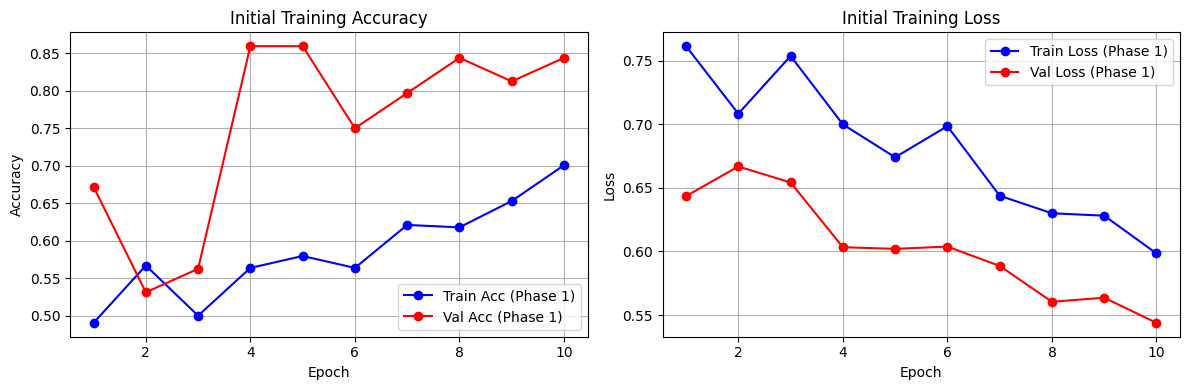

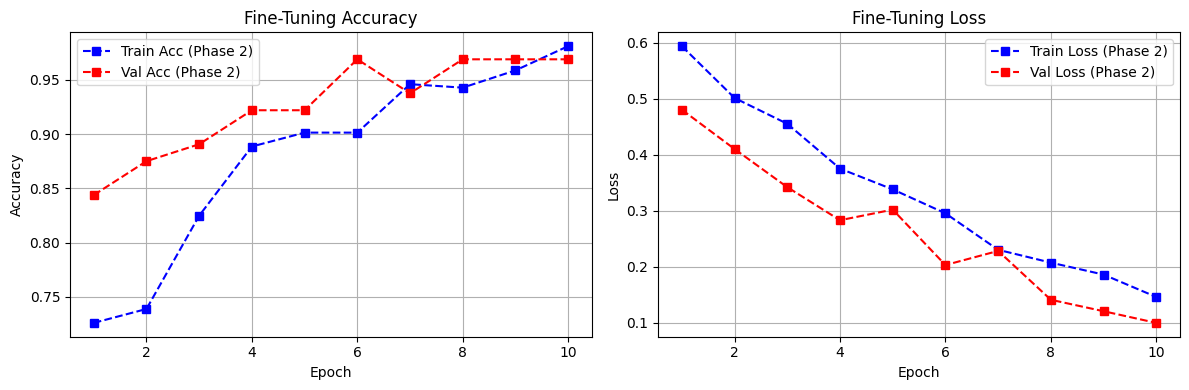

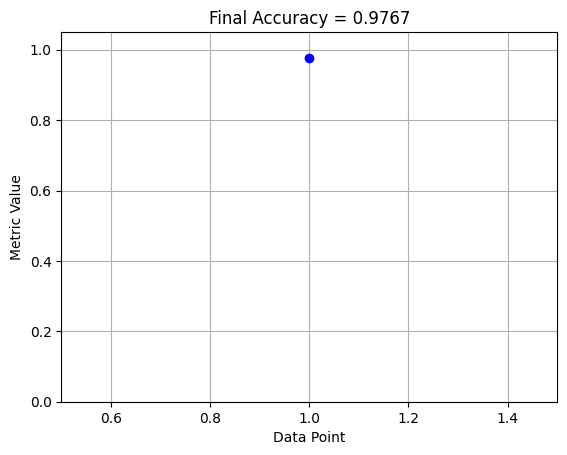

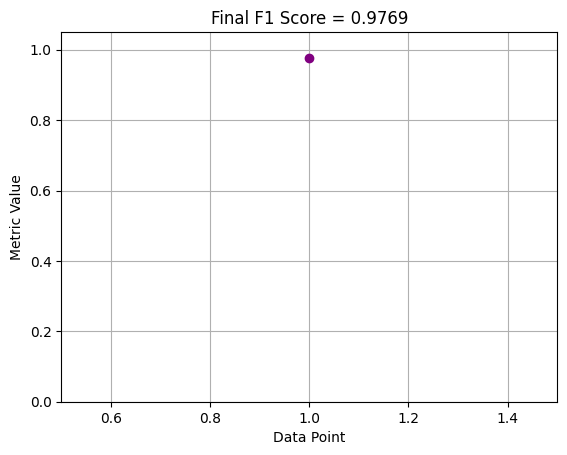

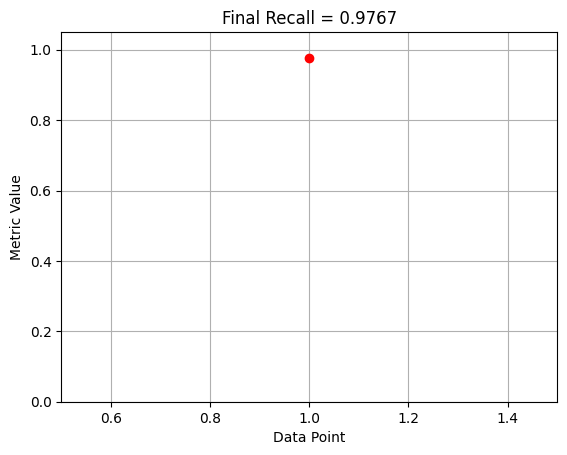

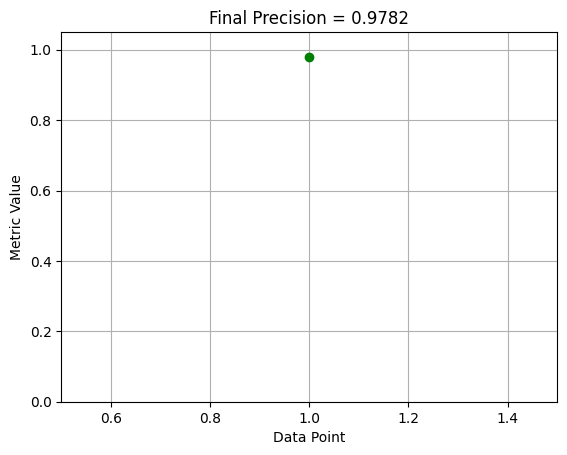

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##############################################################################
# 1) LOGGED TRAINING DATA (INITIAL TRAINING)
#    EPOCHS 1-10
##############################################################################
train_acc_1 = [0.4904, 0.5669, 0.5000, 0.5637, 0.5796, 0.5637, 0.6210, 0.6178, 0.6529, 0.7006]
val_acc_1   = [0.6719, 0.5312, 0.5625, 0.8594, 0.8594, 0.7500, 0.7969, 0.8438, 0.8125, 0.8438]
train_loss_1= [0.7614, 0.7083, 0.7537, 0.6999, 0.6740, 0.6985, 0.6438, 0.6300, 0.6281, 0.5984]
val_loss_1  = [0.6435, 0.6668, 0.6542, 0.6033, 0.6020, 0.6038, 0.5886, 0.5604, 0.5636, 0.5438]

epochs_1 = range(1, 11)  # epochs 1 to 10

##############################################################################
# 2) LOGGED TRAINING DATA (FINE-TUNING)
#    EPOCHS 1-10 (effectively 11-20 overall, but we'll label them 1-10 here)
##############################################################################
train_acc_2 = [0.7261, 0.7389, 0.8248, 0.8885, 0.9013, 0.9013, 0.9459, 0.9427, 0.9586, 0.9809]
val_acc_2   = [0.8438, 0.8750, 0.8906, 0.9219, 0.9219, 0.9688, 0.9375, 0.9688, 0.9688, 0.9688]
train_loss_2= [0.5935, 0.5011, 0.4551, 0.3752, 0.3382, 0.2955, 0.2305, 0.2076, 0.1863, 0.1464]
val_loss_2  = [0.4802, 0.4101, 0.3421, 0.2832, 0.3021, 0.2033, 0.2285, 0.1414, 0.1210, 0.1002]

epochs_2 = range(1, 11)  # epochs 1 to 10 for second phase

##############################################################################
# 3) PLOT (INITIAL TRAINING) - EPOCHS 1-10
##############################################################################
plt.figure(figsize=(12,4))

# Accuracy (phase 1)
plt.subplot(1, 2, 1)
plt.plot(epochs_1, train_acc_1, 'bo-', label='Train Acc (Phase 1)')
plt.plot(epochs_1, val_acc_1,   'ro-', label='Val Acc (Phase 1)')
plt.title('Initial Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss (phase 1)
plt.subplot(1, 2, 2)
plt.plot(epochs_1, train_loss_1, 'bo-', label='Train Loss (Phase 1)')
plt.plot(epochs_1, val_loss_1,   'ro-', label='Val Loss (Phase 1)')
plt.title('Initial Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##############################################################################
# 4) PLOT (FINE-TUNING) - EPOCHS 1-10
##############################################################################
plt.figure(figsize=(12,4))

# Accuracy (phase 2)
plt.subplot(1, 2, 1)
plt.plot(epochs_2, train_acc_2, 'bs--', label='Train Acc (Phase 2)')
plt.plot(epochs_2, val_acc_2,   'rs--', label='Val Acc (Phase 2)')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss (phase 2)
plt.subplot(1, 2, 2)
plt.plot(epochs_2, train_loss_2, 'bs--', label='Train Loss (Phase 2)')
plt.plot(epochs_2, val_loss_2,   'rs--', label='Val Loss (Phase 2)')
plt.title('Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##############################################################################
# 5) FINAL METRICS (FROM LOGS)
##############################################################################
# These were printed after final evaluation:
# Validation Accuracy:  97.67%
# Validation F1 Score:  97.69%
# Validation Recall:    97.67%
# Validation Precision: 97.82%

final_accuracy  = 0.9767
final_f1        = 0.9769
final_recall    = 0.9767
final_precision = 0.9782

##############################################################################
# 6) PLOT FINAL METRICS (SEPARATE SINGLE-POINT GRAPHS)
##############################################################################

# 6.1 Accuracy
plt.figure()
plt.plot([1], [final_accuracy], marker='o', linestyle='-', color='blue')
plt.title(f'Final Accuracy = {final_accuracy:.4f}')
plt.xlim([0.5, 1.5])
plt.ylim([0, 1.05])
plt.xlabel('Data Point')
plt.ylabel('Metric Value')
plt.grid(True)
plt.show()

# 6.2 F1 Score
plt.figure()
plt.plot([1], [final_f1], marker='o', linestyle='-', color='purple')
plt.title(f'Final F1 Score = {final_f1:.4f}')
plt.xlim([0.5, 1.5])
plt.ylim([0, 1.05])
plt.xlabel('Data Point')
plt.ylabel('Metric Value')
plt.grid(True)
plt.show()

# 6.3 Recall
plt.figure()
plt.plot([1], [final_recall], marker='o', linestyle='-', color='red')
plt.title(f'Final Recall = {final_recall:.4f}')
plt.xlim([0.5, 1.5])
plt.ylim([0, 1.05])
plt.xlabel('Data Point')
plt.ylabel('Metric Value')
plt.grid(True)
plt.show()

# 6.4 Precision
plt.figure()
plt.plot([1], [final_precision], marker='o', linestyle='-', color='green')
plt.title(f'Final Precision = {final_precision:.4f}')
plt.xlim([0.5, 1.5])
plt.ylim([0, 1.05])
plt.xlabel('Data Point')
plt.ylabel('Metric Value')
plt.grid(True)
plt.show()


1. **Accuracy Graph**:
   - **Explanation**: This graph shows the accuracy of the model on the validation set. Accuracy is the ratio of correctly predicted instances to the total instances.

2. **Precision Graph**:
   - **Explanation**: Precision indicates the accuracy of positive predictions. It is the ratio of true positive predictions to the sum of true and false positives.

3. **Recall Graph**:
   - **Explanation**: Recall measures the ability of the model to find all relevant cases within the dataset. It is the ratio of true positive predictions to the sum of true positives and false negatives.

4. **F1 Score Graph**:
   - **Explanation**: The F1 score is the harmonic mean of precision and recall. It balances the trade-off between precision and recall, providing a single metric that accounts for both.



 5. **Confusion Matrix**:
   - **Explanation**: The confusion matrix visualizes the performance of the classification model. It shows the counts of true positive, true negative, false positive, and false negative predictions.

6. **ROC Curve for Each Class**:
   - **Explanation**: The ROC curve illustrates the diagnostic ability of the classifier across different threshold settings. Each curve shows the trade-off between true positive rate (sensitivity) and false positive rate for a particular class.

Original CSV columns: ['filename', 'Healthy', 'Sick']
Data sample:
                                             filename  Healthy  Sick
0  1672722154872_jpg.rf.8564176bcc26d04aac101c68f...        0     1
1  1672722154780_jpg.rf.892058b85f2d04eb308938dff...        0     1
2  1672722154867_jpg.rf.85faad3d4c32a9392fe751628...        0     1
3  IMG_20230109_132222_jpg.rf.87d9bfa088e5b692963...        1     0
4  IMG_20230109_132019_jpg.rf.86a303b2424fd4bdea5...        1     0

After label conversion:
                                              images  Healthy  Sick    label
0  1672722154872_jpg.rf.8564176bcc26d04aac101c68f...        0     1     Sick
1  1672722154780_jpg.rf.892058b85f2d04eb308938dff...        0     1     Sick
2  1672722154867_jpg.rf.85faad3d4c32a9392fe751628...        0     1     Sick
3  IMG_20230109_132222_jpg.rf.87d9bfa088e5b692963...        1     0  Healthy
4  IMG_20230109_132019_jpg.rf.86a303b2424fd4bdea5...        1     0  Healthy
Class distribution:
 label
Sick      

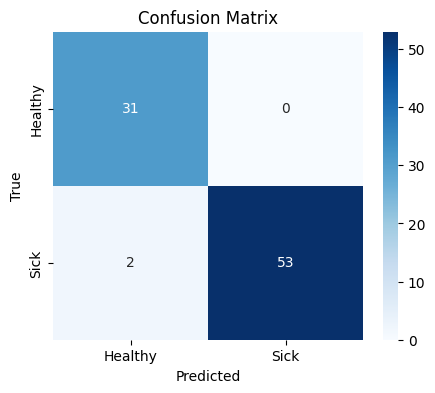

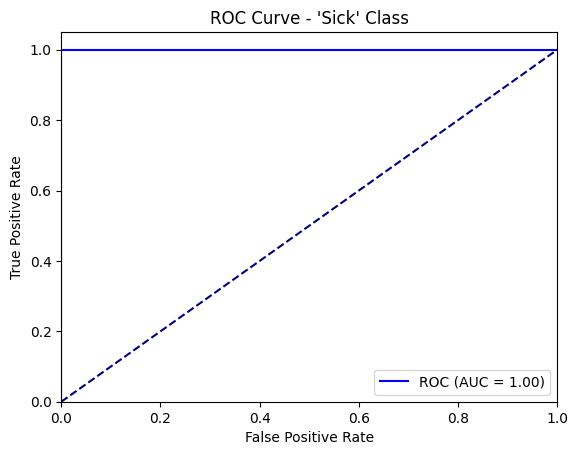

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

##############################################################################
# 1) Define Paths
##############################################################################
base_dir = r"C:/Users/maryc/Downloads/chicken/broiler-chicken-healthy-and-sick"
train_dir = os.path.join(base_dir, "train")
csv_file = os.path.join(train_dir, "_classes.csv")

model_path = "chicken_disease_model.h5"  # Your saved model name

##############################################################################
# 2) Read CSV and Convert (Healthy, Sick) -> Single "label"
##############################################################################
df = pd.read_csv(csv_file)
print("Original CSV columns:", df.columns.tolist())
print("Data sample:\n", df.head())

# The CSV columns are: ["filename", "Healthy", "Sick"].
# We create one column called "label" that is either "Healthy" or "Sick".

def row_to_label(row):
    if row["Healthy"] == 1 and row["Sick"] == 0:
        return "Healthy"
    elif row["Healthy"] == 0 and row["Sick"] == 1:
        return "Sick"
    else:
        # If both are 0 or both are 1, we exclude or handle
        return None

df["label"] = df.apply(row_to_label, axis=1)
# Drop rows where label is None (i.e., (1,1) or (0,0))
df.dropna(subset=["label"], inplace=True)

# Rename "filename" to "images" so we can do x_col="images" easily
df.rename(columns={"filename": "images"}, inplace=True)

print("\nAfter label conversion:")
print(df.head())
print("Class distribution:\n", df["label"].value_counts())

##############################################################################
# 3) Create Validation Generator (Same 20% split as training)
##############################################################################
# We'll do 20% validation_sub
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

batch_size = 32
validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,   # folder containing images
    x_col="images",        # the new column we renamed
    y_col="label",         # the single label ("Healthy" or "Sick")
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",  # for 2-class classification, Keras auto-encodes it
    subset="validation",
    shuffle=False  # important for consistent ordering
)

##############################################################################
# 4) Load Saved Model
##############################################################################
model = tf.keras.models.load_model(model_path)

##############################################################################
# 5) Predictions
##############################################################################
y_true = validation_generator.classes  # integer labels (0 or 1)
y_pred_probs = model.predict(validation_generator)  # shape: (N,2)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

##############################################################################
# 6) Confusion Matrix
##############################################################################
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Class labels from the generator
class_labels = list(validation_generator.class_indices.keys())
print("Class Labels:", class_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

##############################################################################
# 7) ROC Curve (2-class)
##############################################################################
if len(class_labels) == 2:
    # Probability of the "Sick" class (assuming index=1)
    y_prob_sick = y_pred_probs[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true, y_prob_sick)
    auc_val = roc_auc_score(y_true, y_prob_sick)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f"ROC (AUC = {auc_val:.2f})")
    plt.plot([0,1],[0,1], color='navy', linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - 'Sick' Class")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Not plotting ROC because number of classes != 2.")


CHICKEN STOLEN/INTRUDER DETECTION

using mobilessdnet

In [17]:
pip install opencv-python-headless numpy

  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/26/d0/22f68eb23eea053a31655960f133c0be9726c6a881547e6e9e7e2a946c4f/opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


GRAPHS

Number of Detections Over Time:
Tracks the number of detected chickens and intruders over time.

Confidence Levels:
Displays the confidence levels of detections over time.

Missing Chickens Alerts:
Shows when and how many chickens were reported missing over time.

Intruder Alerts:
Shows when and how many intruders were detected over time.

Heatmap of Detections:
Displays a heatmap of the locations of chicken and intruder detections in the video frame

Alert: Intruder 2_76 detected!
Alert: Intruder 2_69 detected!
Alert: Intruder 4_69 detected!
Alert: Intruder -5_66 detected!
Alert: Intruder 2_43 detected!
Alert: Intruder -4_44 detected!
Alert: Intruder 0_38 detected!
Alert: Intruder 3_35 detected!
Alert: Intruder 3_90 detected!
Alert: Intruder 5_58 detected!
Alert: Intruder 5_60 detected!
Alert: Intruder 6_41 detected!
Alert: Intruder 20_73 detected!
Alert: Intruder -2_86 detected!
Alert: Intruder 0_150 detected!
Alert: Intruder 3_77 detected!
Alert: Intruder -1_89 detected!
Alert: Intruder 3_43 detected!
Alert: Intruder 3_78 detected!
Alert: Intruder 11_94 detected!
Alert: Intruder -3_66 detected!
Alert: Intruder 36_193 detected!
Alert: Intruder 19_241 detected!
Alert: Intruder 6_284 detected!
Alert: Intruder 3_258 detected!
Alert: Intruder 2_270 detected!
Alert: Intruder 0_314 detected!


C:\Users\maryc\AppData\Local\Temp\ipykernel_7704\1557847555.py:148: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  intruder_count = intruder_alerts_df.groupby(intruder_alerts_df['time'].dt.floor('T')).size()


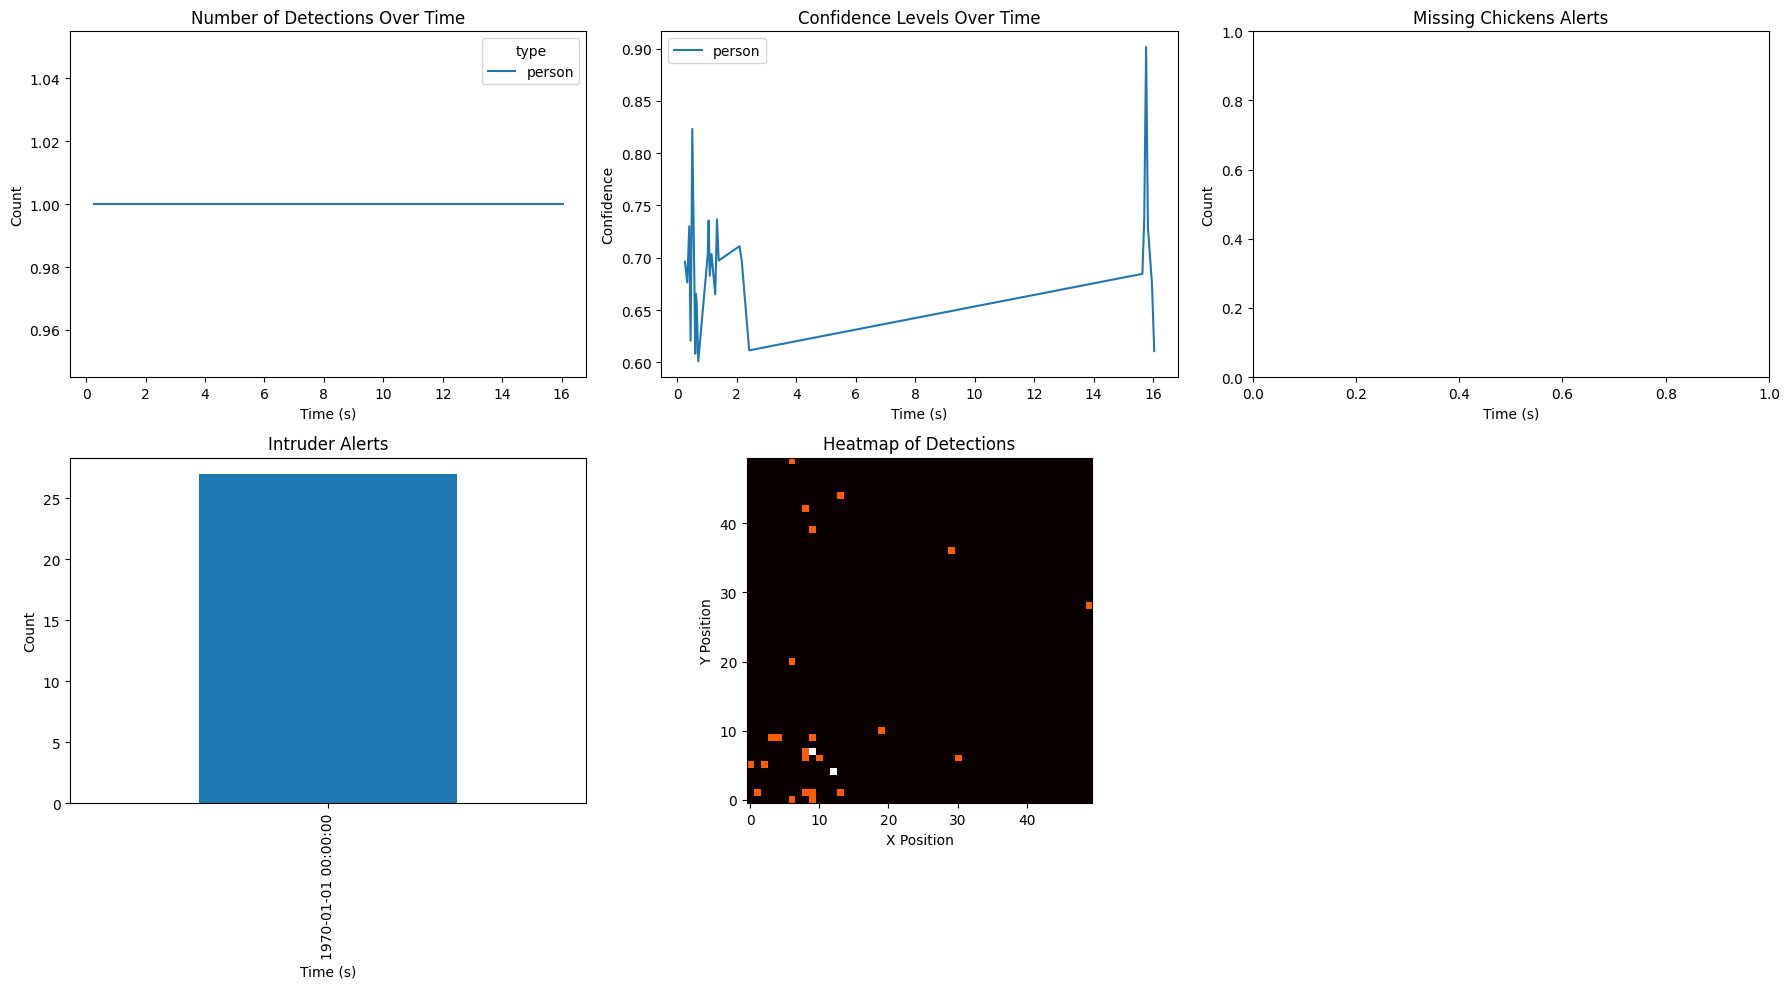

In [25]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the pre-trained MobileNet SSD model
net = cv2.dnn.readNetFromCaffe('MobileNetSSD_deploy.prototxt.txt', 'MobileNetSSD_deploy.caffemodel')

# Class labels MobileNet SSD can detect (based on the model's training)
class_labels = {0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle',
                6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable',
                12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant',
                17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}

# Define class IDs for chickens and intruders
CHICKEN_CLASS_ID = 3  # Typically 'bird' is used as a proxy for chicken in generic models
INTRUDER_CLASS_IDS = [12, 15, 8]  # 'dog', 'person', 'cat'

# Set the video source
video_path = '0704(1).mp4'  # Update with your video path
cap = cv2.VideoCapture(video_path)

# Initialize dictionaries and lists for tracking and plotting
chicken_dict = {}
intruder_dict = {}

# Data for plots
detection_data = []
missing_chickens_data = []
intruder_alerts_data = []
detection_positions = []

# Get video properties
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
duration = frame_count / fps

start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame for faster processing
    frame_resized = cv2.resize(frame, (300, 300))
    blob = cv2.dnn.blobFromImage(frame_resized, 0.007843, (300, 300), 127.5)

    # Pass the blob through the network
    net.setInput(blob)
    detections = net.forward()

    current_chickens = {}
    current_intruders = {}

    timestamp = time.time() - start_time  # Use elapsed time for consistent timestamp

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.6:  # Confidence threshold
            class_id = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            x, y, w, h = box.astype(int)

            # Create unique identifier for tracking
            unique_id = f"{x}_{y}"

            if class_id == CHICKEN_CLASS_ID:
                # Chicken detection
                current_chickens[unique_id] = (x, timestamp)
                color = (0, 255, 0)  # Green for chickens
                label = 'Chicken'
            elif class_id in INTRUDER_CLASS_IDS:
                # Intruder detection
                current_intruders[unique_id] = (x, timestamp)
                color = (0, 0, 255)  # Red for intruders
                label = class_labels[class_id]
            else:
                continue

            # Draw bounding boxes
            cv2.rectangle(frame, (x, y), (w, h), color, 2)
            cv2.putText(frame, f'{label} {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Append data for plots
            detection_data.append({'time': timestamp, 'type': label, 'confidence': confidence})
            detection_positions.append((x, y))

    # Check for missing chickens
    for chicken_id in list(chicken_dict.keys()):
        if chicken_id not in current_chickens:
            missing_chickens_data.append({'time': timestamp, 'chicken_id': chicken_id})
            print(f"Alert: Chicken {chicken_id} is missing!")
            del chicken_dict[chicken_id]

    # Check for new intruders
    for intruder_id in current_intruders:
        if intruder_id not in intruder_dict:
            intruder_alerts_data.append({'time': timestamp, 'intruder_id': intruder_id})
            print(f"Alert: Intruder {intruder_id} detected!")

    # Update dictionaries
    chicken_dict.update(current_chickens)
    intruder_dict.update(current_intruders)

# Release resources
cap.release()

# Convert data to DataFrames for plotting
detection_df = pd.DataFrame(detection_data)
missing_chickens_df = pd.DataFrame(missing_chickens_data)
intruder_alerts_df = pd.DataFrame(intruder_alerts_data)

# Plot the graphs
plt.figure(figsize=(18, 10))

# 1. Number of Detections Over Time
plt.subplot(2, 3, 1)
detection_count = detection_df.groupby(['time', 'type']).size().unstack(fill_value=0)
detection_count.plot(ax=plt.gca(), title='Number of Detections Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Count')

# 2. Confidence Levels Over Time
plt.subplot(2, 3, 2)
for label, group in detection_df.groupby('type'):
    plt.plot(group['time'], group['confidence'], label=label)
plt.title('Confidence Levels Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Confidence')
plt.legend()

# 3. Missing Chickens Alerts
plt.subplot(2, 3, 3)
if not missing_chickens_df.empty:
    missing_chickens_df['time'] = pd.to_datetime(missing_chickens_df['time'], unit='s')
    missing_count = missing_chickens_df.groupby(missing_chickens_df['time'].dt.floor('T')).size()
    missing_count.plot(kind='bar', ax=plt.gca())
plt.title('Missing Chickens Alerts')
plt.xlabel('Time (s)')
plt.ylabel('Count')

# 4. Intruder Alerts
plt.subplot(2, 3, 4)
if not intruder_alerts_df.empty:
    intruder_alerts_df['time'] = pd.to_datetime(intruder_alerts_df['time'], unit='s')
    intruder_count = intruder_alerts_df.groupby(intruder_alerts_df['time'].dt.floor('T')).size()
    intruder_count.plot(kind='bar', ax=plt.gca())
plt.title('Intruder Alerts')
plt.xlabel('Time (s)')
plt.ylabel('Count')

# 5. Heatmap of Detections
plt.subplot(2, 3, 5)
if detection_positions:
    x_positions, y_positions = zip(*detection_positions)
    heatmap, xedges, yedges = np.histogram2d(x_positions, y_positions, bins=50)
    plt.imshow(heatmap.T, origin='lower', cmap='hot', interpolation='nearest')
plt.title('Heatmap of Detections')
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.tight_layout()
plt.show()


GRAPHS

Number of Detections Over Time:
Tracks the number of detected chickens and intruders over time.

Confidence Levels:
Displays the confidence levels of detections over time.

Missing Chickens Alerts:
Shows when and how many chickens were reported missing over time.

Intruder Alerts:
Shows when and how many intruders were detected over time.

Heatmap of Detections:
Displays a heatmap of the locations of chicken and intruder detections in the video frame

Alert: Intruder 324_281 detected!
Alert: Intruder 329_278 detected!
Alert: Intruder 330_281 detected!
Alert: Intruder 315_277 detected!
Alert: Intruder 314_280 detected!
Alert: Chicken 307_251 is missing!
Alert: Intruder 311_254 detected!
Alert: Intruder 289_242 detected!
Alert: Intruder 282_248 detected!
Alert: Chicken 286_214 is missing!
Alert: Chicken 283_225 is missing!
Alert: Chicken 281_221 is missing!
Alert: Chicken 289_218 is missing!
Alert: Chicken 295_217 is missing!
Alert: Chicken 288_219 is missing!
Alert: Chicken 254_227 is missing!
Alert: Chicken 254_235 is missing!
Alert: Chicken 279_236 is missing!
Alert: Chicken 281_236 is missing!
Alert: Chicken 272_237 is missing!
Alert: Chicken 242_230 is missing!
Alert: Chicken 193_229 is missing!
Alert: Chicken 184_231 is missing!
Alert: Intruder 183_229 detected!
Alert: Chicken 181_233 is missing!
Alert: Chicken 197_231 is missing!
Alert: Chicken 198_219 is missing!
Alert: Chicken 179_221 is missing!
Alert: Chicken 183_219 is mis

C:\Users\maryc\AppData\Local\Temp\ipykernel_7704\609851172.py:138: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  missing_count = missing_chickens_df.groupby(missing_chickens_df['time'].dt.floor('T')).size()
C:\Users\maryc\AppData\Local\Temp\ipykernel_7704\609851172.py:148: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  intruder_count = intruder_alerts_df.groupby(intruder_alerts_df['time'].dt.floor('T')).size()


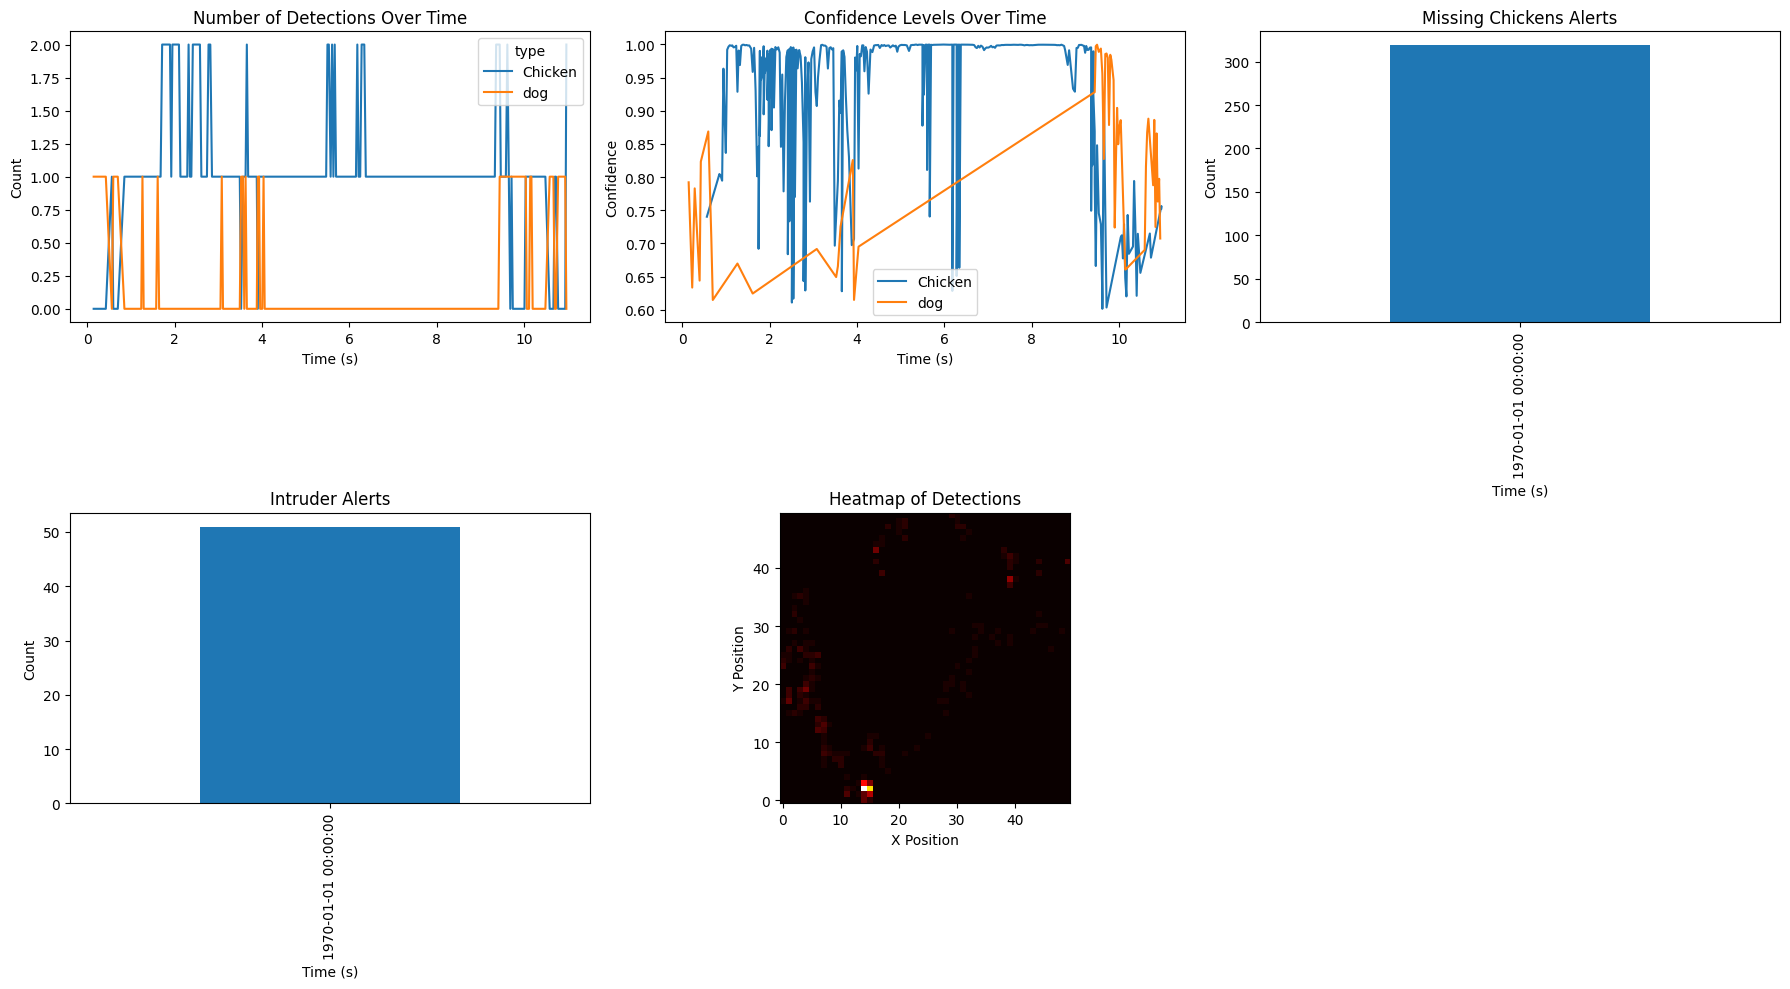

In [26]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the pre-trained MobileNet SSD model
net = cv2.dnn.readNetFromCaffe('MobileNetSSD_deploy.prototxt.txt', 'MobileNetSSD_deploy.caffemodel')

# Class labels MobileNet SSD can detect (based on the model's training)
class_labels = {0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle',
                6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable',
                12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant',
                17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}

# Define class IDs for chickens and intruders
CHICKEN_CLASS_ID = 3  # Typically 'bird' is used as a proxy for chicken in generic models
INTRUDER_CLASS_IDS = [12, 15, 8]  # 'dog', 'person', 'cat'

# Set the video source
video_path = '856986-hd_1920_1080_25fps.mp4'  # Update with your video path
cap = cv2.VideoCapture(video_path)

# Initialize dictionaries and lists for tracking and plotting
chicken_dict = {}
intruder_dict = {}

# Data for plots
detection_data = []
missing_chickens_data = []
intruder_alerts_data = []
detection_positions = []

# Get video properties
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
duration = frame_count / fps

start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame for faster processing
    frame_resized = cv2.resize(frame, (300, 300))
    blob = cv2.dnn.blobFromImage(frame_resized, 0.007843, (300, 300), 127.5)

    # Pass the blob through the network
    net.setInput(blob)
    detections = net.forward()

    current_chickens = {}
    current_intruders = {}

    timestamp = time.time() - start_time  # Use elapsed time for consistent timestamp

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.6:  # Confidence threshold
            class_id = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            x, y, w, h = box.astype(int)

            # Create unique identifier for tracking
            unique_id = f"{x}_{y}"

            if class_id == CHICKEN_CLASS_ID:
                # Chicken detection
                current_chickens[unique_id] = (x, timestamp)
                color = (0, 255, 0)  # Green for chickens
                label = 'Chicken'
            elif class_id in INTRUDER_CLASS_IDS:
                # Intruder detection
                current_intruders[unique_id] = (x, timestamp)
                color = (0, 0, 255)  # Red for intruders
                label = class_labels[class_id]
            else:
                continue

            # Draw bounding boxes
            cv2.rectangle(frame, (x, y), (w, h), color, 2)
            cv2.putText(frame, f'{label} {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Append data for plots
            detection_data.append({'time': timestamp, 'type': label, 'confidence': confidence})
            detection_positions.append((x, y))

    # Check for missing chickens
    for chicken_id in list(chicken_dict.keys()):
        if chicken_id not in current_chickens:
            missing_chickens_data.append({'time': timestamp, 'chicken_id': chicken_id})
            print(f"Alert: Chicken {chicken_id} is missing!")
            del chicken_dict[chicken_id]

    # Check for new intruders
    for intruder_id in current_intruders:
        if intruder_id not in intruder_dict:
            intruder_alerts_data.append({'time': timestamp, 'intruder_id': intruder_id})
            print(f"Alert: Intruder {intruder_id} detected!")

    # Update dictionaries
    chicken_dict.update(current_chickens)
    intruder_dict.update(current_intruders)

# Release resources
cap.release()

# Convert data to DataFrames for plotting
detection_df = pd.DataFrame(detection_data)
missing_chickens_df = pd.DataFrame(missing_chickens_data)
intruder_alerts_df = pd.DataFrame(intruder_alerts_data)

# Plot the graphs
plt.figure(figsize=(18, 10))

# 1. Number of Detections Over Time
plt.subplot(2, 3, 1)
detection_count = detection_df.groupby(['time', 'type']).size().unstack(fill_value=0)
detection_count.plot(ax=plt.gca(), title='Number of Detections Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Count')

# 2. Confidence Levels Over Time
plt.subplot(2, 3, 2)
for label, group in detection_df.groupby('type'):
    plt.plot(group['time'], group['confidence'], label=label)
plt.title('Confidence Levels Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Confidence')
plt.legend()

# 3. Missing Chickens Alerts
plt.subplot(2, 3, 3)
if not missing_chickens_df.empty:
    missing_chickens_df['time'] = pd.to_datetime(missing_chickens_df['time'], unit='s')
    missing_count = missing_chickens_df.groupby(missing_chickens_df['time'].dt.floor('T')).size()
    missing_count.plot(kind='bar', ax=plt.gca())
plt.title('Missing Chickens Alerts')
plt.xlabel('Time (s)')
plt.ylabel('Count')

# 4. Intruder Alerts
plt.subplot(2, 3, 4)
if not intruder_alerts_df.empty:
    intruder_alerts_df['time'] = pd.to_datetime(intruder_alerts_df['time'], unit='s')
    intruder_count = intruder_alerts_df.groupby(intruder_alerts_df['time'].dt.floor('T')).size()
    intruder_count.plot(kind='bar', ax=plt.gca())
plt.title('Intruder Alerts')
plt.xlabel('Time (s)')
plt.ylabel('Count')

# 5. Heatmap of Detections
plt.subplot(2, 3, 5)
if detection_positions:
    x_positions, y_positions = zip(*detection_positions)
    heatmap, xedges, yedges = np.histogram2d(x_positions, y_positions, bins=50)
    plt.imshow(heatmap.T, origin='lower', cmap='hot', interpolation='nearest')
plt.title('Heatmap of Detections')
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.tight_layout()
plt.show()
